### Multivariate Time Series Forecasting by application of Informer (Transformer) on Weather Dataset
-Lookback window = 336

-Forecast window = 96



In [14]:
!git clone https://github.com/zhouhaoyi/Informer2020.git
!ls

fatal: destination path 'Informer2020' already exists and is not an empty directory.
Informer2020  sample_data  weather_dataset


In [15]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

## Experiments: Train and Test

In [16]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [17]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os

In [18]:
args = dotdict()

args.root_path = './weather_dataset/'
args.data_path = 'WTH.csv'
df = pd.read_csv(os.path.join(args.root_path, args.data_path))
df.head(2)

,date,Visibility,DryBulbFarenheit,DryBulbCelsius,WetBulbFarenheit,DewPointFarenheit,DewPointCelsius,RelativeHumidity,WindSpeed,WindDirection,StationPressure,Altimeter,WetBulbCelsius
0,1/1/2010 0:00,10.0,16,-9,13,7,-14,67,7,130,21.65,30.35,-10.3
1,1/1/2010 1:00,10.0,16,-9,13,7,-14,67,5,150,21.64,30.34,-10.3


In [20]:
args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'WTH' # data
# args.root_path = './weather_dataset/'
# args.data_path = 'WTH_zero_mean_normalized.csv'
# df = pd.read_csv(os.path.join(args.root_path, args.data_path))


args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'WetBulbCelsius' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

# args.seq_len = 96 # input sequence length of Informer encoder
args.seq_len = 336 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
# args.pred_len = 24 # prediction sequence length
args.pred_len = 96 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 12 # encoder input size
args.dec_in = 12 # decoder input size
args.c_out = 12 # output size
args.factor = 5 # probsparse attn factor ---> ProbSparse self-attention is incorporated by allowing each key to only attend to the u dominant queries
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
# args.dropout = 0.05 # dropout
args.dropout = 0.1 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
#args.freq = 'h'

args.batch_size = 32
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [21]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [22]:
# Set augments by using data name
data_parser = {
    'WTH':{'data':'WTH.csv','T':'WetBulbCelsius','M':[12,12,12],'S':[1,1,1],'MS':[12,12,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [23]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [24]:
print('Args in experiment:')
print(args)

Args in experiment:
{'root_path': './weather_dataset/', 'data_path': 'WTH.csv', 'model': 'informer', 'data': 'WTH', 'features': 'M', 'target': 'WetBulbCelsius', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 336, 'label_len': 48, 'pred_len': 96, 'enc_in': 12, 'dec_in': 12, 'c_out': 12, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.1, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 'h'}


In [25]:
Exp = Exp_Informer

In [26]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_WTH_ftM_sl336_ll48_pl96_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 24113
val 3413
test 6917
	iters: 100, epoch: 1 | loss: 0.5963429
	speed: 0.2636s/iter; left time: 1164.9505s
	iters: 200, epoch: 1 | loss: 0.5968914
	speed: 0.1908s/iter; left time: 824.0847s
	iters: 300, epoch: 1 | loss: 0.5215358
	speed: 0.1971s/iter; left time: 831.6348s
	iters: 400, epoch: 1 | loss: 0.4889888
	speed: 0.1928s/iter; left time: 794.1363s
	iters: 500, epoch: 1 | loss: 0.5003924
	speed: 0.1980s/iter; left time: 795.8571s
	iters: 600, epoch: 1 | loss: 0.5269721
	speed: 0.1963s/iter; left time: 769.1910s
	iters: 700, epoch: 1 | loss: 0.4588235
	speed: 0.1973s/iter; left time: 753.5359s
Epoch: 1 cost time: 153.6850609779358
Epoch: 1, Steps: 753 | Train Loss: 0.5223780 Vali Loss: 0.8089491 Test Loss: 0.5876369
Validation loss decreased (inf --> 0.808949).  Saving model ...
Updating learning rate to 0.0001
	i

## Prediction

In [29]:
import os

# set saved model path
setting = 'informer_WTH_ftM_sl336_ll48_pl96_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

In [30]:
exp = Exp(args)

exp.predict(setting, True)

Use GPU: cuda:0
pred 1


In [31]:
# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

(1, 96, 12)

### More details about Prediction - prediction function

In [32]:
# here is the detailed code of function predict

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')

    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()

    preds = []

    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)

        pred = outputs.detach().cpu().numpy()#.squeeze()

        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])

    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    np.save(folder_path+'real_prediction.npy', preds)

    return preds


In [33]:
# you can also use this prediction function to get result
prediction = predict(exp, setting, True)

pred 1


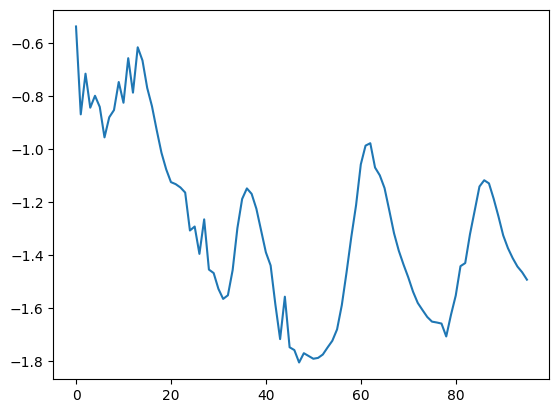

In [34]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()

### More details


In [35]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader

In [36]:
Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

freq = args.detail_freq

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target,
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [37]:
len(data_set), len(data_loader)

(6917, 6917)

## Visualization

In [38]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((6912, 96, 12), (6912, 96, 12))

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

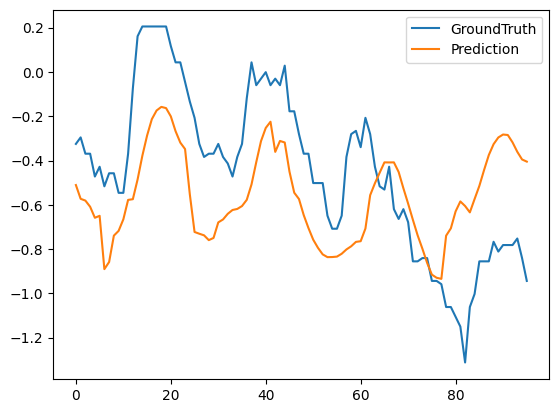

In [40]:
# draw "WetBulbCelsius" prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

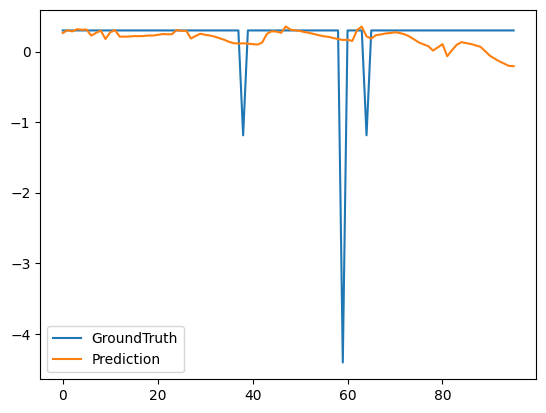

In [41]:
# draw "Visibility" prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()